In [2]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [3]:
root_dir = '/home/ayadav7/'
train_data_files = os.listdir(os.path.join(root_dir, 'preprocessed_data'))

In [4]:
x_files = [f for f in train_data_files if f.startswith('X_')]
y_files = [f for f in train_data_files if f.startswith('y_')]

x_files.sort()
y_files.sort()

x_files = x_files[1:11]
y_files = y_files[1:11]

# Split file paths into training and testing sets
x_train_files, x_test_files, y_train_files, y_test_files = train_test_split(
    x_files, y_files, test_size=0.2, random_state=42
)

In [5]:
# Function to normalize data using min-max normalization for each channel
def min_max_normalize_channel_wise(data):
    normalized_data = np.empty_like(data)
    num_channels = data.shape[-1]
    for i in range(num_channels):
        min_val = np.min(data[..., i])
        max_val = np.max(data[..., i])
        normalized_data[..., i] = (data[..., i] - min_val) / (max_val - min_val)
    return normalized_data

# Function to load, normalize, and combine data
def load_and_normalize_data(x_files, y_files):
    X_combined = []
    y_combined = []

    for i in tqdm(range(len(x_files)), desc="Loading and Normalizing Data"):
        X = np.nan_to_num(np.load(os.path.join(root_dir, 'preprocessed_data', x_files[i])), nan=0.0)
        y = np.load(os.path.join(root_dir, 'preprocessed_data', y_files[i]))

        # Normalize each channel separately
        X = min_max_normalize_channel_wise(X)

        # Reshape X: (30, 896, 896, 18) -> (30 * 896 * 896, 18)
        X_reshaped = X.reshape(-1, X.shape[-1])
        X_combined.append(X_reshaped)

        # Reshape y: (1, 896, 896, 1) -> (896 * 896,)
        y_reshaped = y.reshape(-1)
        y_combined.append(y_reshaped)

    # Combine all the data
    X_combined = np.vstack(X_combined)
    y_combined = np.hstack(y_combined)

    return X_combined, y_combined

In [6]:
# Load and normalize training data
X_train, y_train = load_and_normalize_data(x_train_files, y_train_files)

# Load and normalize testing data
X_test, y_test = load_and_normalize_data(x_test_files, y_test_files)

Loading and Normalizing Data: 100%|██████████| 2/2 [00:35<00:00, 17.93s/it]


In [7]:
def resample_data(X, y, non_zero_fraction=0.9, zero_fraction=0.1):
    # Identify non-zero and zero indices
    non_zero_indices = np.where(y != 0)[0]
    zero_indices = np.where(y == 0)[0]

    # Sample indices
    sampled_non_zero_indices = np.random.choice(non_zero_indices, size=int(len(non_zero_indices) * non_zero_fraction), replace=False)
    sampled_zero_indices = np.random.choice(zero_indices, size=int(len(zero_indices) * zero_fraction), replace=False)

    # Combine and shuffle indices
    sampled_indices = np.concatenate([sampled_non_zero_indices, sampled_zero_indices])
    np.random.shuffle(sampled_indices)

    # Resample X and y
    X_resampled = X[sampled_indices]
    y_resampled = y[sampled_indices]

    return X_resampled, y_resampled

In [13]:
X_train_resampled, y_train_resampled = resample_data(X_train, y_train, non_zero_fraction=0.2, zero_fraction=0.8)

In [14]:
X_train_resampled.shape

(75444590, 18)

In [15]:
def random_sample(X, y, fraction=0.1):
    num_samples = int(X.shape[0] * fraction)
    sampled_indices = np.random.choice(X.shape[0], num_samples, replace=False)
    return X[sampled_indices], y[sampled_indices]

# Randomly sample 10% of the rows
X_train_sampled, y_train_sampled = random_sample(X_train_resampled, y_train_resampled)

In [16]:
X_train_sampled.shape

(7544459, 18)

In [17]:
y_train_sampled[y_train_sampled>0].shape[0]/y_train_sampled.shape[0]

0.3478201684176427

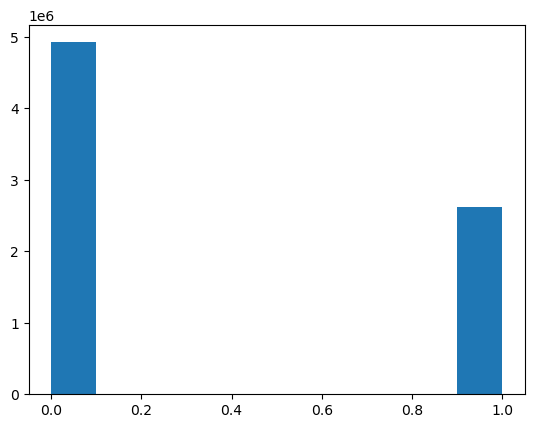

In [18]:
y_train_sampled[y_train_sampled>0] = 1

plt.hist(y_train_sampled)
plt.show()

In [45]:
# t1 = datetime.datetime.now()
# # Train the Random Forest model on the resampled data
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train_resampled, y_train_resampled)
# print('took {} seconds...'.format(datetime.datetime.now()-t1))

In [19]:
# Number of trees in the forest
n_estimators = 100

# Initialize the RandomForestClassifier without fitting it
rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42, warm_start=True)

# Fit each tree individually and provide updates
print("Training RandomForestClassifier with verbose output...")
for i in tqdm(range(n_estimators), desc="Training Trees"):
    rf_model.n_estimators = i + 1
    rf_model.fit(X_train_sampled, y_train_sampled)

Training RandomForestClassifier with verbose output...


Training Trees: 100%|██████████| 100/100 [1:04:28<00:00, 38.69s/it]


In [ ]:
# Evaluate the model
y_pred_train = rf_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
print(f"Training Mean Squared Error: {train_mse}")

y_pred_test = rf_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f"Testing Mean Squared Error: {test_mse}")

In [21]:
# new_X_list = [np.load(f) for f in x_test_files[:1]]  # Replace with actual new data file paths
new_X_combined, _ = load_and_normalize_data(['X_2018_334_12_g17.nc.npy'], ['X_2018_334_12_g17.nc.npy'])  # Second parameter is dummy
new_predictions = rf_model.predict(new_X_combined)

Loading and Normalizing Data: 100%|██████████| 1/1 [00:19<00:00, 19.82s/it]


In [22]:
# Reshape the predictions back to the original image shape
new_predictions_reshaped = new_predictions.reshape(30, 896, 896, 1)  # Adjust based on actual data
print(f"Predictions shape: {new_predictions_reshaped.shape}")

Predictions shape: (30, 896, 896, 1)


/tmp/ipykernel_2236414/3333302610.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar


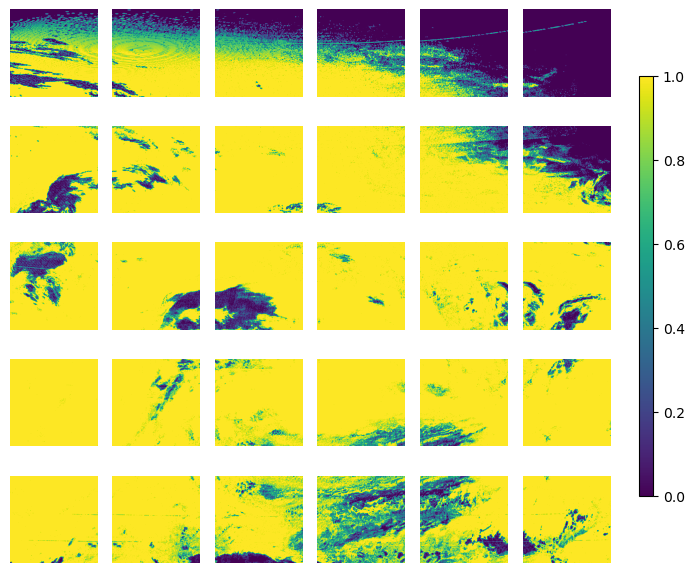

In [29]:
fig, ax = plt.subplots(5, 6, figsize=(7, 6))
k1 = 0

# Loop through subplots and display images
for i in range(5):
    for j in range(6):
        im = ax[i, j].imshow(new_predictions_reshaped[k1, :, :, 0], cmap='viridis')  # Using 'viridis' colormap
        k1 += 1
        ax[i, j].axis('off')

# Add a colorbar to the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to accommodate colorbar
plt.show()

(array([ 4705688.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 19378792.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

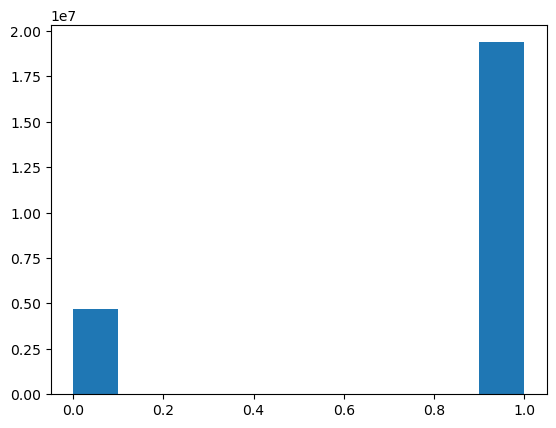

In [26]:
plt.hist(new_predictions_reshaped.flatten())

In [24]:
y = np.load(os.path.join(root_dir,'preprocessed_data','y_2018_334_12_g17.nc.npy'))

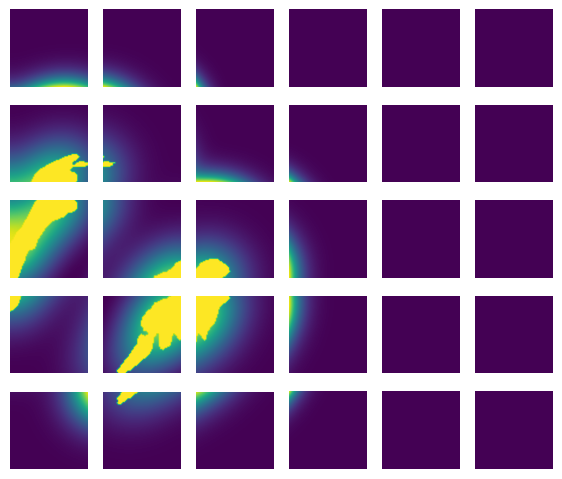

In [25]:
fig, ax = plt.subplots(5,6,figsize=(7,6))

k1 = 0
for i in range(5):
    for j in range(6):
        ax[i,j].imshow(y [k1,:,:,0])
        k1 = k1 + 1
        ax[i,j].axis('off')
plt.show()

In [20]:
import joblib

joblib_file = "/home/ayadav7/models/random_forest_model.pkl"
joblib.dump(rf_model, joblib_file)

['/home/ayadav7/models/random_forest_model.pkl']